In [163]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fuzzy matching
from thefuzz import process


In [164]:
outfield_df = pd.read_csv("combined_data/outfield_stats.csv")
# print number of rows in outfield_df
print(outfield_df.shape[0])

14696


# Preprocessing

In [165]:
# Parameters
MINUTE_CUT_OFF = 450 # 5 games
AGE_VALUATION_YEAR = 2024

Remove duplicates

In [166]:
print(f"Number of outfield player records before dropping duplicates: {len(outfield_df)}")
outfield_df = outfield_df.drop_duplicates()
print(f"Number of outfield player records after dropping duplicates: {len(outfield_df)}")

Number of outfield player records before dropping duplicates: 14696
Number of outfield player records after dropping duplicates: 14696


Visualising and dropping rows where with players that didn't play enough for sample to be representative

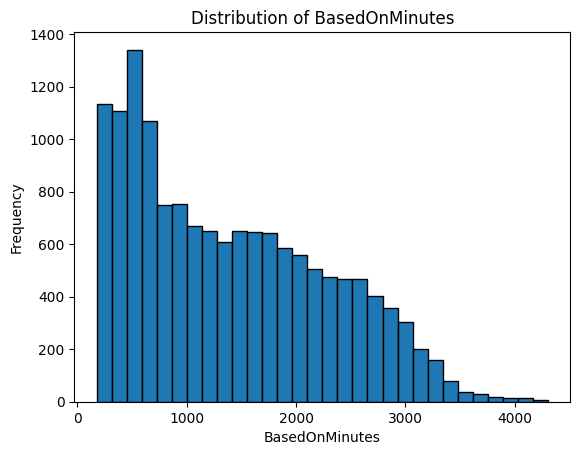

In [167]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

In [168]:
# Dropping all entries with BasedOnMinutes less than MINUTE_CUT_OFF min
print(f"Number of outfield outfield records before filtering: {len(outfield_df)}")
outfield_df = outfield_df[outfield_df['BasedOnMinutes'] >= MINUTE_CUT_OFF]
print(f"Number of outfield outfield records after filtering: {len(outfield_df)}")

Number of outfield outfield records before filtering: 14696
Number of outfield outfield records after filtering: 12567


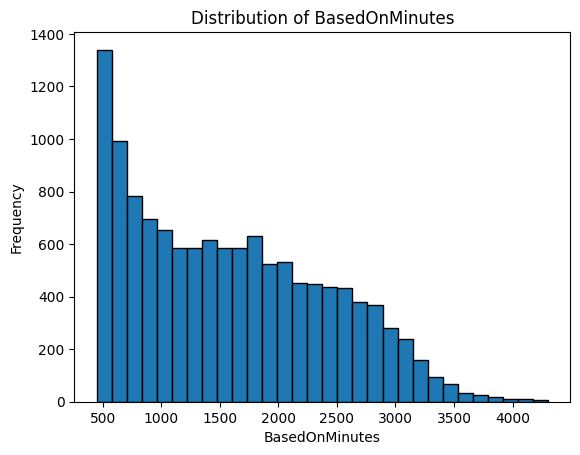

In [169]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

Dropping rows with "Last 365 Days Men's Big 5 Leagues"

In [170]:
# Drop rows where scouting_period is "Last 365 Days Men's Big 5 Leagues"
outfield_df = outfield_df[outfield_df['scouting_period'] != "Last 365 Days Men's Big 5 Leagues"]

Dropping Percentile data 

In [171]:
print(f"Number of outfield player records before dropping Percentile: {outfield_df.shape[1]}")
columns_to_drop = [col for col in outfield_df.columns if 'Percentile' in col]
outfield_df = outfield_df.drop(columns=columns_to_drop)
print(f"Number of outfield player records after dropping Percentile: {outfield_df.shape[1]}")

Number of outfield player records before dropping Percentile: 238
Number of outfield player records after dropping Percentile: 121


Handling na values

In [172]:
null_rows = outfield_df[outfield_df.isnull().any(axis=1)]
null_rows.to_excel('transformed_data/null_rows.xlsx', index=False)

In [173]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 1347


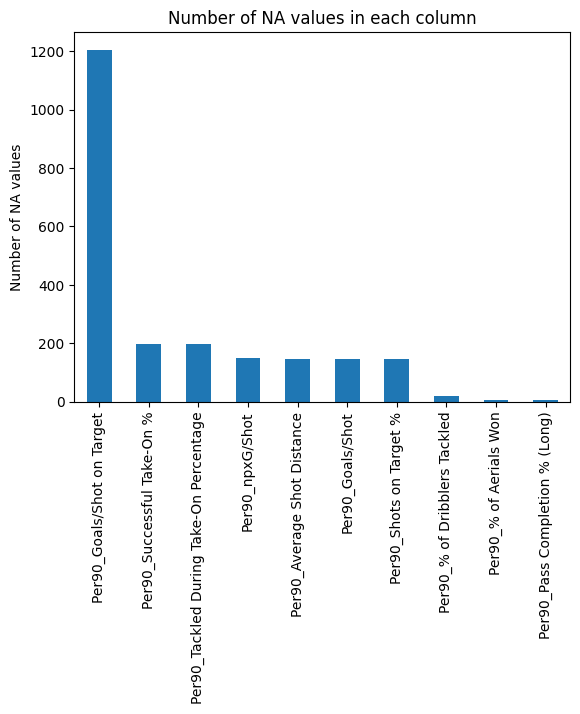

In [174]:
# Visualise columns with na values, sort from highest to lowest
na_columns = outfield_df.isnull().sum()
na_columns = na_columns[na_columns > 0]
na_columns = na_columns.sort_values(ascending=False)
na_columns.plot(kind='bar')
plt.ylabel('Number of NA values')
plt.title('Number of NA values in each column')
plt.show()

In [175]:
# If Per90 is not dropped
na_columns_goal_related_per90 = ['Per90_Goals/Shot on Target', 
                                 'Per90_npxG/Shot', 
                                 'Per90_Average Shot Distance', 
                                 'Per90_Goals/Shot', 
                                 'Per90_Shots on Target %']
na_columns_dribble_related_per90 = ['Per90_Successful Take-On %',
                                    'Per90_Tackled During Take-On Percentage']
na_columns_others = ['Per90_% of Dribblers Tackled',
                    'Per90_% of Aerials Won',
                    'Per90_Pass Completion % (Long)']
def get_existing_columns(df, *column_lists):
    existing_cols = []
    for col_list in column_lists:
        existing_cols.extend([col for col in col_list if col in df.columns])
    return existing_cols

# Get all existing columns from the three lists
existing_columns = get_existing_columns(outfield_df, 
                                        na_columns_goal_related_per90, 
                                        na_columns_dribble_related_per90, 
                                        na_columns_others)

outfield_df[existing_columns] = outfield_df[existing_columns].fillna(0)

In [176]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 0


Combining rows to ensure that one entry is tagged to only one unique player

In [177]:
print(outfield_df.dtypes)

Player                             object
Versus                             object
BasedOnMinutes                      int64
scouting_period                    object
Per90_% of Aerials Won            float64
                                   ...   
Per90_npxG/Shot                   float64
Per90_npxG: Non-Penalty xG        float64
Per90_xA: Expected Assists        float64
Per90_xAG: Exp. Assisted Goals    float64
Per90_xG: Expected Goals          float64
Length: 121, dtype: object


In [178]:
# Drop non-numeric column "scouting_period"
outfield_df = outfield_df.drop(columns=["scouting_period"], errors="ignore")

# Define numeric columns excluding categorical ones
numeric_cols = [col for col in outfield_df.columns if col not in ['Player', 'Versus', 'BasedOnMinutes']]

# Compute weighted averages for numeric stats
weighted_avg_df = outfield_df.groupby("Player").apply(
    lambda group: pd.Series(
        {col: np.average(group[col], weights=group["BasedOnMinutes"]) for col in numeric_cols}
    )
).reset_index()

# Drop "BasedOnMinutes" since it's no longer needed
outfield_df = weighted_avg_df.drop(columns=["BasedOnMinutes"], errors="ignore")

outfield_df.head(10)

/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_43057/2090541934.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_df = outfield_df.groupby("Player").apply(


,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Def Pen),Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xA: Expected Assists,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals
0,Aaron Cresswell,53.744897,54.478054,1.050578,1.232776,0.126076,23.713051,5.019973,1.003463,33.071370,...,3.829974,67.727667,31.363400,0.152007,0.151503,0.053259,0.028676,0.105276,0.125962,0.028676
1,Aaron Wan-Bissaka,46.982567,74.928410,1.019510,0.916619,0.080330,15.204835,5.334216,1.442013,31.436534,...,4.094386,66.273364,27.892252,0.126624,0.086534,0.081324,0.025679,0.061230,0.061986,0.025679
2,Aarón Martín,36.244264,50.992465,0.973289,0.585540,0.083322,23.944634,4.585236,0.963194,26.358914,...,2.536466,55.738766,23.858121,0.156446,0.164019,0.045687,0.026725,0.158879,0.140334,0.030512
3,Abakar Sylla,60.826103,78.107119,1.155755,1.817705,0.000000,10.692593,5.070812,1.795272,49.081027,...,11.074247,74.790661,32.954726,0.280075,0.070945,0.119135,0.059902,0.008909,0.015017,0.059902
4,Abdallah Sima,44.736643,55.210985,3.062034,2.557767,0.076327,13.790835,4.024681,0.688130,20.934739,...,1.179373,34.769628,13.939379,0.138356,0.400423,0.129369,0.308988,0.072494,0.091646,0.308988
5,Abde Ezzalzouli,35.426583,49.861756,1.670368,1.138612,0.057175,17.081718,4.622961,1.007898,32.577278,...,0.433680,50.471529,18.268653,0.189530,0.382689,0.101974,0.288295,0.125131,0.094424,0.331884
6,Abdel Abqar,51.063499,62.392677,1.410073,1.469475,0.023141,9.301006,3.594567,1.072091,22.109771,...,6.541582,44.346048,18.890894,0.476898,0.033538,0.070307,0.029603,0.016769,0.010000,0.029603
7,Abderrahman Rebbach,28.920923,19.804448,1.855058,0.740313,0.000000,19.967381,3.705997,1.039259,23.574761,...,0.814843,42.853213,13.638072,0.144316,0.255157,0.041895,0.075684,0.185684,0.183526,0.075684
8,Abdou Harroui,56.677188,66.019429,1.034472,1.283734,0.224991,20.646058,5.029081,1.479448,32.737092,...,1.311983,55.645782,28.995680,0.224423,0.358547,0.097238,0.270767,0.105878,0.087781,0.292905
9,Abdoulaye Bamba,50.535541,63.460631,0.855189,0.876290,0.036874,15.179507,4.395631,0.636778,27.951347,...,2.975673,54.549500,26.523191,0.175473,0.050388,0.032457,0.007457,0.048741,0.046943,0.007457


Merge with age_data

In [179]:
age_valuation_df = pd.read_csv("combined_data/age-valuation.csv")
age_valuation_df = age_valuation_df[age_valuation_df['season_start_year'] == AGE_VALUATION_YEAR]
# drop duplicates
age_valuation_df = age_valuation_df.drop_duplicates(subset=['Player'])

In [180]:
for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, age_valuation_df['Player'])

    if score >= 70:
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

outfield_df = outfield_df.merge(
    age_valuation_df[['Player', 'age']], 
    on="Player", 
    how="left"
)

print(f"Number of na values in Age: {outfield_df['age'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['age'])
print(f"Number of na values in Age after dropping: {outfield_df['age'].isna().sum()}")

print("Merging completed successfully!")
outfield_df.head(10)

Number of na values in Age: 207
Number of na values in Age after dropping: 0
Merging completed successfully!


,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xA: Expected Assists,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals,age
0,Aaron Cresswell,53.744897,54.478054,1.050578,1.232776,0.126076,23.713051,5.019973,1.003463,33.071370,...,67.727667,31.363400,0.152007,0.151503,0.053259,0.028676,0.105276,0.125962,0.028676,35.0
1,Aaron Wan-Bissaka,46.982567,74.928410,1.019510,0.916619,0.080330,15.204835,5.334216,1.442013,31.436534,...,66.273364,27.892252,0.126624,0.086534,0.081324,0.025679,0.061230,0.061986,0.025679,27.0
2,Aarón Martín,36.244264,50.992465,0.973289,0.585540,0.083322,23.944634,4.585236,0.963194,26.358914,...,55.738766,23.858121,0.156446,0.164019,0.045687,0.026725,0.158879,0.140334,0.030512,27.0
3,Abakar Sylla,60.826103,78.107119,1.155755,1.817705,0.000000,10.692593,5.070812,1.795272,49.081027,...,74.790661,32.954726,0.280075,0.070945,0.119135,0.059902,0.008909,0.015017,0.059902,22.0
4,Abdallah Sima,44.736643,55.210985,3.062034,2.557767,0.076327,13.790835,4.024681,0.688130,20.934739,...,34.769628,13.939379,0.138356,0.400423,0.129369,0.308988,0.072494,0.091646,0.308988,23.0
5,Abde Ezzalzouli,35.426583,49.861756,1.670368,1.138612,0.057175,17.081718,4.622961,1.007898,32.577278,...,50.471529,18.268653,0.189530,0.382689,0.101974,0.288295,0.125131,0.094424,0.331884,23.0
6,Abdel Abqar,51.063499,62.392677,1.410073,1.469475,0.023141,9.301006,3.594567,1.072091,22.109771,...,44.346048,18.890894,0.476898,0.033538,0.070307,0.029603,0.016769,0.010000,0.029603,25.0
7,Abner,28.920923,19.804448,1.855058,0.740313,0.000000,19.967381,3.705997,1.039259,23.574761,...,42.853213,13.638072,0.144316,0.255157,0.041895,0.075684,0.185684,0.183526,0.075684,24.0
8,Abdou Harroui,56.677188,66.019429,1.034472,1.283734,0.224991,20.646058,5.029081,1.479448,32.737092,...,55.645782,28.995680,0.224423,0.358547,0.097238,0.270767,0.105878,0.087781,0.292905,27.0
9,Abdoulaye Bamba,50.535541,63.460631,0.855189,0.876290,0.036874,15.179507,4.395631,0.636778,27.951347,...,54.549500,26.523191,0.175473,0.050388,0.032457,0.007457,0.048741,0.046943,0.007457,34.0


Log the distribution of player market value

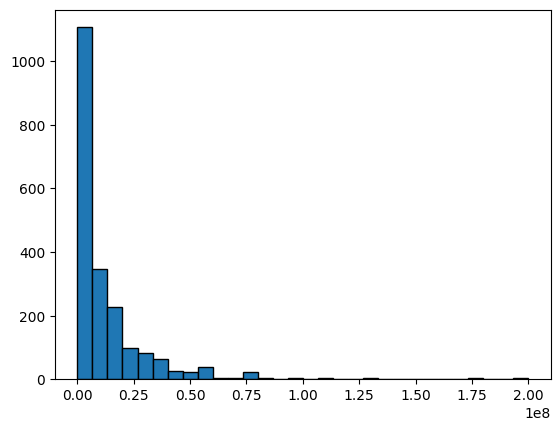

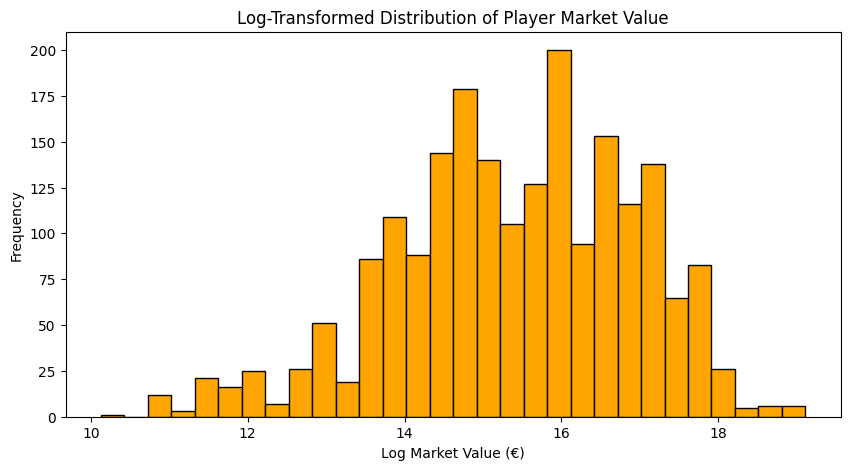

In [181]:

# visualise distribution of player market value
plt.hist(age_valuation_df['player_market_value_euro'], bins=30, edgecolor='k')

# log visualisation
log_values = np.log1p(age_valuation_df['player_market_value_euro'])  # log(1 + x) to avoid log(0) issues

# Log visualisation
plt.figure(figsize=(10, 5))
plt.hist(log_values, bins=30, edgecolor='k', color='orange')
plt.xlabel('Log Market Value (€)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Player Market Value')
plt.show()

# convert player_market_value to a log scale
age_valuation_df['player_market_value_euro'] = np.log(age_valuation_df['player_market_value_euro'])


Merge data with valuation

In [182]:


# Change 'Player' value in outfield_df to that in age_valuation_df if fuzzy matching
for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, age_valuation_df['Player'])

    if score >= 70:
        # replace name with best_match
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

# Merge only player_market_value_euro for 2024 season
outfield_df = outfield_df.merge(
    age_valuation_df[['Player', 'player_market_value_euro']], 
    on="Player", 
    how="left"
)

# Print number of na values in player_market_value_euro
print(f"Number of na values in player_market_value_euro: {outfield_df['player_market_value_euro'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['player_market_value_euro'])
print(f"Number of na values in player_market_value_euro after dropping: {outfield_df['player_market_value_euro'].isna().sum()}")

Number of na values in player_market_value_euro: 1
Number of na values in player_market_value_euro after dropping: 0


In [183]:
outfield_df.head()
# save to csv
outfield_df.to_csv("preprocessed_data/outfield_unique.csv", index=False)